# TimeSHAP

## Import

In [82]:
import numpy as np

import matplotlib.pyplot as plt

# Import functions from modular scripts
from TimeSHAP import (
    plot_predictions, avg_rul,  get_random_sequence,
    local_event_explainer, plot_local_event_explanation,
    compute_event_explanation, plot_event_explanation,
)
from Load_and_Preprocess_Aachen import preprocess_aachen_dataset
from LSTM_Model_Training import load_model_structure_and_weights, plot_predictions_vs_actual, plot_residuals



from timeshap.explainer.pruning import local_pruning

import mat4py as mpy

import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

import os

import tensorflow as tf

import plotly.graph_objects as go
from plotly.subplots import make_subplots


## Test data

This section defines parameters for data preprocessing and analysis:
- `file_path`: Path to the Aachen dataset (ISEA battery degradation data).
- `test_cell_count = 3`: Number of test cells, balancing computational efficiency and representativeness.
- `random_state = 52`: Ensures reproducibility of random splits.
- `n_samples = 1000`: Number of background samples for SHAP, chosen for computational feasibility.
- `eol_capacity = 0.65`: End-of-Life threshold (65% of initial capacity), a common industry standard for battery RUL.
- `global_relative = True`: Enables relative position normalization for SHAP aggregation.

In [77]:
# Define the file path for the dataset
file_path = '/Users/sigurdgjerdingen/Student/Master kode/Master_Herstad-Gjerdingen/data/Degradation_Prediction_Dataset_ISEA.mat'

# Define the number of test cells to be used
test_cell_count = 3

# Set the global random seed for reproducibility
random_state = 52
np.random.seed(random_state)

# Number of sampels to be used for the SHAP explainer
n_samples = 1000

# EOL threshold
eol_capacity = 0.65

global_relative = True 

## Load data

In [78]:
# Load and preprocess the Aachen dataset
preprocessed_full = preprocess_aachen_dataset(
    file_path, eol_capacity=eol_capacity, test_cell_count=test_cell_count,
    random_state=random_state, phase=None, log_transform=False  # No log transform applied
)

# Extract training, validation, and test sets for LSTM input and normalized RUL targets
X_train_lstm = preprocessed_full["X_train"]  # Training sequences
X_test_lstm = preprocessed_full["X_test"]    # Test sequences
y_test_norm = preprocessed_full["y_test"]    # Normalized test RUL
y_max = preprocessed_full["y_max"]           # Maximum RUL for rescaling

## Load Model

In [79]:
model = load_model_structure_and_weights('model_20250217_RUL65')
f = lambda x: model.predict(x)

Checking for model files in the following paths:
Structure file: Aachen/Models/model_20250217_RUL65.structure.json
Weights file: Aachen/Models/model_20250217_RUL65.weights.h5
Model loaded from Aachen/Models/model_20250217_RUL65.structure.json and Aachen/Models/model_20250217_RUL65.weights.h5


## Evaluate Model

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3934e-04 - mae: 0.0159
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Rescaled Test MAE: 27.099970756098628


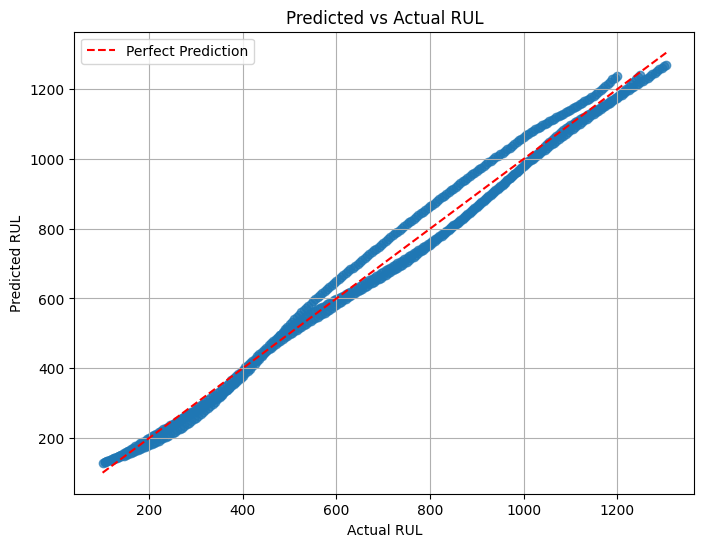

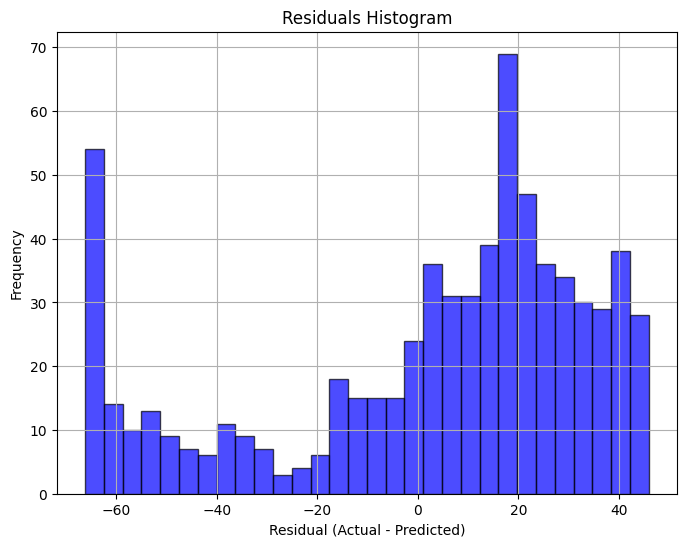

In [83]:
test_loss, test_mae = model.evaluate(X_test_lstm, y_test_norm, verbose=1)
test_mae_rescaled = test_mae * y_max
y_pred = model.predict(X_test_lstm).flatten() * y_max

y_test_rescaled = y_test_norm * y_max
print(f"Rescaled Test MAE: {test_mae_rescaled}")

plot_predictions_vs_actual(y_test_rescaled, y_pred)
plot_residuals(y_test_rescaled, y_pred)

### Background data

In [6]:
average_event = avg_rul(X_train_lstm)

average_event.shape

(1, 1)

In [7]:
# Squeeze the last dimension for easier handling (from (7998, 288, 1) to (7998, 288))
data_2d = X_train_lstm.squeeze(axis=2)

# Create a mask where values are non-zero
mask = data_2d != 0

# Compute the sum of non-zero values for each time step
sum_per_timestep = np.sum(data_2d * mask, axis=0)

# Count non-zero values for each time step
count_per_timestep = np.sum(mask, axis=0)

# Avoid division by zero by setting mean to 0 where no non-zero values exist
# (though with 7998 sequences, this is unlikely unless all values at a timestep are padded)
mean_per_timestep = np.where(count_per_timestep > 0, 
                            sum_per_timestep / count_per_timestep, 
                            0)

# Reshape to (288, 1) to match your data’s feature dimension
mean_per_timestep = mean_per_timestep.reshape(288, 1)

average_event = mean_per_timestep

average_event

array([[0.97932778],
       [0.97550132],
       [0.97170276],
       [0.96790543],
       [0.96412372],
       [0.96039098],
       [0.95668851],
       [0.95297585],
       [0.94931539],
       [0.94567606],
       [0.94205113],
       [0.93846234],
       [0.93492331],
       [0.93137603],
       [0.92786362],
       [0.9243965 ],
       [0.92093531],
       [0.9175298 ],
       [0.91413442],
       [0.91077915],
       [0.907445  ],
       [0.90415192],
       [0.90087607],
       [0.89767013],
       [0.8944558 ],
       [0.89130402],
       [0.88817173],
       [0.88506231],
       [0.8820085 ],
       [0.87898314],
       [0.87599759],
       [0.8730239 ],
       [0.87012228],
       [0.86723938],
       [0.86439343],
       [0.8615669 ],
       [0.8587772 ],
       [0.85600883],
       [0.85329804],
       [0.85057013],
       [0.84790505],
       [0.84524664],
       [0.84260759],
       [0.84000755],
       [0.83742906],
       [0.83486931],
       [0.83231117],
       [0.829

Text(0, 0.5, 'History average')

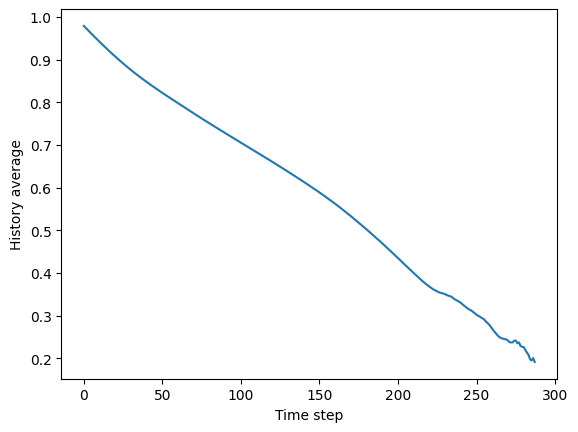

In [39]:
# plot the average_event
plt.plot(average_event)
plt.xlabel('Time step')
plt.ylabel('History average')

# Get a random sequence from the test set


## Local Explanations

The SHAP value for feature \(i\) is computed as:

$$
\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N|-|S|-1)!}{|N|!} [f(S \cup \{i\}) - f(S)]
$$

where \(N\) is the set of all features, \(S\) is a subset excluding \(i\), and \(f\) is the model prediction function. TimeSHAP extends this to temporal events, aggregating contributions over sequence steps.

In [8]:
from timeshap.explainer.pruning import local_pruning

# Define prediction function
f = lambda x: model.predict(x, verbose=0)

prun_dict = {'tol': 0.05}

# Select a random test sequence
seq_idx = np.random.randint(0, len(X_test_lstm))

### Why different Shap-results

- Non-Trimmed Sequences: The explanation includes padded zeros, which leads to low but volatile Shapley values across the entire sequence—even in regions that the model largely ignores.

- Trimmed Sequences: Only the meaningful, nonzero parts are considered. The Shapley values become more consistent and focused on the parts of the sequence that truly affect the model's prediction.

This behavior suggests that your model is effectively ignoring the padded sections during prediction, and the explanation method is reflecting that by producing more stable, interpretable results when the padding is removed.

### Normalize by relative Position

When you average over all sequences for each absolute event index, you run into two issues:

- Early Events: For long sequences, many of the early events are padded (or absent) and show near‐zero Shapley values, which “pulls” the mean down—even if some short sequences have higher values there.
- Late Events: For long sequences, the later events (which have high Shapley values) occur only in those sequences. If many sequences are shorter and do not have those events at all, then the average at those indices is computed over a smaller sample, and the overall mean can be “dragged” down by the large number of zeros (or missing values) from the shorter sequences.

Therfore Shapley values can be aggregated across relative data into bins.

In [32]:
# Get a random trimmed sequence from the test set.
trimmed_sequence = get_random_sequence(X_test_lstm, 660, trimmed=True)
print(trimmed_sequence.shape)

x = trimmed_sequence.shape[1]  # Get the number of time steps (e.g., 261)
trimmed_average_event = average_event[:x].reshape(1, x, 1)  # Slice first x elements and reshape

# Compute the local event explanation for the trimmed sequence
event_explanation = local_event_explainer(f, trimmed_sequence, trimmed_average_event, pruned_idx=0, nsamples=1000)

# Output the explanation
print(event_explanation)

trimmed_sequence.shape



Selected index: 660
Trimmed sequence shape: (1, 209, 1)
(1, 209, 1)
     Shapley Value  Sequence Value
0         0.000000        0.983138
1         0.000000        0.977949
2         0.000000        0.972805
3         0.000000        0.967710
4         0.000000        0.962664
..             ...             ...
204       0.020382        0.326768
205      -0.001175        0.322081
206      -0.028766        0.317331
207      -0.049946        0.312509
208      -0.064280        0.307602

[209 rows x 2 columns]


(1, 209, 1)

In [26]:
# Plot the event explanation.
plot_local_event_explanation(event_explanation)

In [16]:
trimmed_sequence

array([[[0.9719559 ],
        [0.968568  ],
        [0.9651899 ],
        [0.9618224 ],
        [0.95846623],
        [0.9551222 ],
        [0.951791  ],
        [0.94847345],
        [0.94517034],
        [0.94188243],
        [0.9386105 ],
        [0.93535525],
        [0.9321175 ],
        [0.92889804],
        [0.92569757],
        [0.9225169 ],
        [0.91935676],
        [0.9162179 ],
        [0.91310126],
        [0.9100074 ],
        [0.9069372 ],
        [0.9038914 ],
        [0.90087074],
        [0.89787596],
        [0.89490795],
        [0.8919674 ],
        [0.8890551 ],
        [0.88617176],
        [0.8833182 ],
        [0.88049513],
        [0.8777034 ],
        [0.87494373],
        [0.8722164 ],
        [0.8695172 ],
        [0.86684436],
        [0.864197  ],
        [0.8615745 ],
        [0.85897595],
        [0.8564007 ],
        [0.853848  ],
        [0.851317  ],
        [0.8488069 ],
        [0.8463171 ],
        [0.8438467 ],
        [0.84139496],
        [0

## Global Explanations

In [34]:
# Count non-zero time steps per sequence
non_zero_counts = np.sum(X_test_lstm != 0, axis=(1, 2))  # Shape (7998,)
mask = non_zero_counts >= 100  # Keep sequences with at least 100 non-zero steps
filtered_sequences = X_test_lstm[mask]  # Shape (n_filtered, 288, 1)

filtered_sequences.shape

# Trim to first 100 time steps
trimmed_sequences = filtered_sequences[:, :100, :]  # Shape (n_filtered, 100, 1)

trimmed_sequences.shape

# Trimmed average event
trimmed_average_event = average_event[:100].reshape(1, 100)


In [35]:
event_data_bin = compute_event_explanation(f, trimmed_sequences, baseline=trimmed_average_event, relative=False, random_seed=random_state, nsamples=1000, verbose=True)


Sequence 0: original length = 100, trimmed length = 100, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Sequence 1: original length = 100, trimmed length = 100, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Sequence 2: original length = 100, trimmed length = 100, event indices: [0

In [37]:
global_event_chart = plot_event_explanation(event_data_bin, relative=False)
global_event_chart.show()

In [17]:
event_data = compute_event_explanation(f, X_test_lstm, baseline=average_event, relative=False, random_seed=random_state, nsamples=1000, num_bins=30, verbose=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Sequence 0: original length = 272, trimmed length = 21, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sequence 1: original length = 272, trimmed length = 22, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sequence 2: original length = 272, trimmed length = 23, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sequence 3: original length = 272, trimmed length = 24, event indices: [0, 1, 2, 3, 4, 5, 

In [18]:
global_event_chart = plot_event_explanation(event_data, relative=False)
global_event_chart.show()

In [ ]:
# --- Stability Evaluation --- Not implemented
#stability_results = evaluate_stability(f, X_test_lstm, noise_level=0.01, num_runs=5, num_bins=20)
#plot_stability(stability_results)

In [46]:
trimmed_sequence = get_random_sequence(X_test_lstm, 206, trimmed=True)

Selected index: 206
Trimmed sequence shape: (1, 227, 1)


In [74]:
# Compute the local event explanation for the trimmed sequence.
event_explanation = local_event_explainer(f, trimmed_sequence, average_event, pruned_idx=0, nsamples=1000)

# Plot the event explanation.
plot_local_event_explanation(event_explanation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [69]:
prun_dict = {'tol': 0.005}

# Pruning the sequence
pruned_sequence, prun_idx = local_pruning(f, 
                                data=trimmed_sequence, 
                                pruning_dict=prun_dict,
                                baseline=average_event)
                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

In [70]:
pruned_sequence

,Coalition,t (event index),Shapley Value
0,Sum of contribution of events > t,0,1.490116e-08
1,Sum of contribution of events ≤ t,0,-4.549102e-01
2,Sum of contribution of events > t,-1,-4.831913e-01
3,Sum of contribution of events ≤ t,-1,2.828106e-02
4,Sum of contribution of events > t,-2,-6.569493e-01
...,...,...,...
451,Sum of contribution of events ≤ t,-225,1.306966e-03
452,Sum of contribution of events > t,-226,-4.544932e-01
453,Sum of contribution of events ≤ t,-226,-4.169792e-04
454,Sum of contribution of events > t,-227,-4.549102e-01


In [71]:
prun_idx

-51

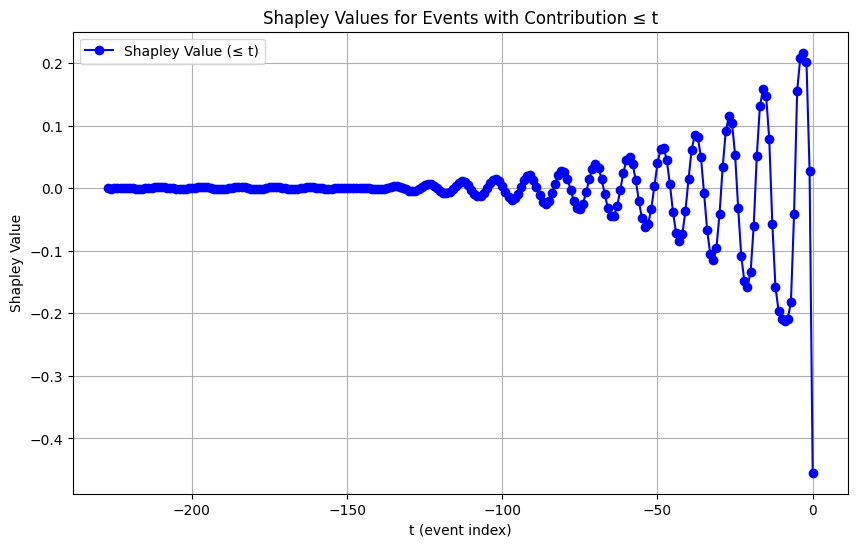

In [72]:
df = pruned_sequence

# Filter the DataFrame for rows where the 'Coalition' column indicates contributions ≤ t.
# (Adjust the string if your DataFrame uses a different notation.)
df_filtered = df[df['Coalition'] == 'Sum of contribution of events ≤ t']

# Now, plot the filtered data.
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['t (event index)'], df_filtered['Shapley Value'],
         marker='o', linestyle='-', color='blue', label='Shapley Value (≤ t)')

plt.xlabel('t (event index)')
plt.ylabel('Shapley Value')
plt.title('Shapley Values for Events with Contribution ≤ t')
plt.legend()
plt.grid(True)
plt.show()



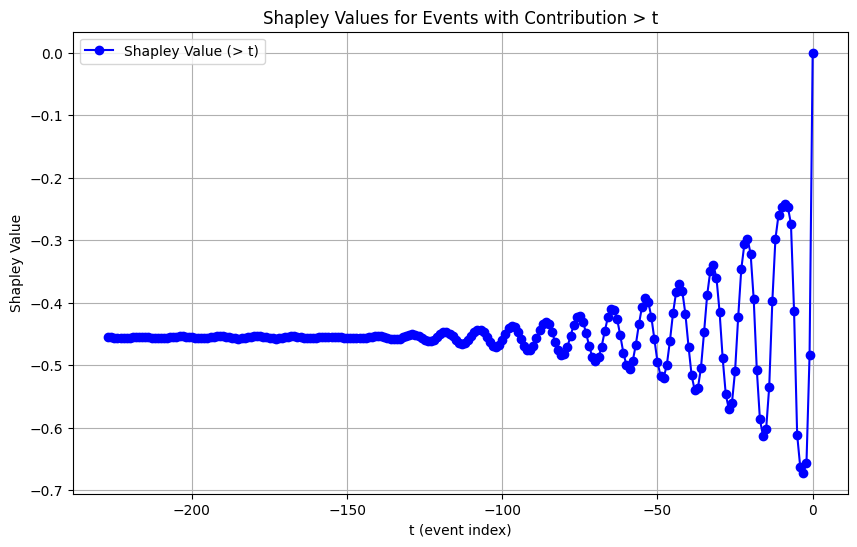

In [73]:
df = pruned_sequence

# Filter the DataFrame for rows where the 'Coalition' column indicates contributions > t.
df_filtered = df[df['Coalition'] == 'Sum of contribution of events > t']

# Now, plot the filtered data.
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['t (event index)'], df_filtered['Shapley Value'],
         marker='o', linestyle='-', color='blue', label='Shapley Value (> t)')

plt.xlabel('t (event index)')
plt.ylabel('Shapley Value')
plt.title('Shapley Values for Events with Contribution > t')
plt.legend()
plt.grid(True)
plt.show()


### Why different Shap-results

- Non-Trimmed Sequences: The explanation includes padded zeros, which leads to low but volatile Shapley values across the entire sequence—even in regions that the model largely ignores.

- Trimmed Sequences: Only the meaningful, nonzero parts are considered. The Shapley values become more consistent and focused on the parts of the sequence that truly affect the model's prediction.

This behavior suggests that your model is effectively ignoring the padded sections during prediction, and the explanation method is reflecting that by producing more stable, interpretable results when the padding is removed.

### Normalize by relative Position

When you average over all sequences for each absolute event index, you run into two issues:

- Early Events: For long sequences, many of the early events are padded (or absent) and show near‐zero Shapley values, which “pulls” the mean down—even if some short sequences have higher values there.
- Late Events: For long sequences, the later events (which have high Shapley values) occur only in those sequences. If many sequences are shorter and do not have those events at all, then the average at those indices is computed over a smaller sample, and the overall mean can be “dragged” down by the large number of zeros (or missing values) from the shorter sequences.

Therfore Shapley values can be aggregated across relative data into bins.

## CNN - models

### Preprocessing

In [28]:
# Load the dataset
file_path = "../../data/Degradation_Prediction_Dataset_ISEA.mat"  
data_loader = mpy.loadmat(file_path)
df = pd.DataFrame.from_dict(data_loader["TDS"])

In [29]:
# -------------------------------------
# Define the percentage for end-of-life
# -------------------------------------
eol_percentage = 0.65  # e.g., 0.65 for EOL65, or 0.80 for EOL80

# --------------------------------------------------------
# Function to compute EOL and RUL given a specified fraction
# --------------------------------------------------------
def compute_eol_and_rul(row, fraction):
    history_cap = np.array(row["History"])
    history_cycles = np.array(row["History_Cycle"])
    target_cap = np.array(row["Target_expanded"])
    target_cycles = np.array(row["Target_Cycle_Expanded"])

    eol_cycle, rul = np.nan, np.nan
    
    # Handle edge cases: missing data
    if len(history_cap) == 0 or len(history_cycles) == 0:
        return pd.Series({"EOL": eol_cycle, "RUL": rul})
    
    # The threshold is fraction * initial_capacity
    initial_capacity = history_cap[0]
    threshold = fraction * initial_capacity

    # If the last historical capacity is already below threshold, we can't compute a future RUL
    if history_cap[-1] <= threshold:
        return pd.Series({"EOL": np.nan, "RUL": np.nan})
    
    # Handle target data edge cases
    if len(target_cap) == 0 or len(target_cycles) == 0:
        return pd.Series({"EOL": eol_cycle, "RUL": rul})

    # Find the first index in target where capacity drops below threshold
    below_threshold_indices = np.where(target_cap < threshold)[0]
    if len(below_threshold_indices) > 0:
        eol_index = below_threshold_indices[0]
        eol_cycle = target_cycles[eol_index]

    # Compute RUL = EOL cycle - last history cycle
    if not pd.isna(eol_cycle):
        last_history_cycle = history_cycles[-1]
        rul = eol_cycle - last_history_cycle

    return pd.Series({"EOL": eol_cycle, "RUL": rul})

# -------------------------------------------------------
# Apply the function to your DataFrame (df) and filter
# -------------------------------------------------------
df[["EOL", "RUL"]] = df.apply(lambda row: compute_eol_and_rul(row, eol_percentage), axis=1)

# Drop rows where RUL is NaN (invalid entries)
df_filtered = df.dropna(subset=["RUL"])

# (Optional) Filter out any rows whose history has fewer than 120 time steps
df_filtered = df_filtered[df_filtered["History"].apply(lambda x: len(x) >= 120)]


In [30]:
# Define bins and labels
bins = [0, 200, 300, 400, 500, 600, 700, np.inf]
labels = ["0-200", "200-300", "300-400", "400-500", "500-600", "600-700", "700+"]

# Apply binning to the RUL column
df_filtered["RUL_binned"] = pd.cut(df_filtered["RUL"], bins=bins, labels=labels, include_lowest=True)

# Inspect bin distribution
print("Binned RUL Distribution:\n", df_filtered["RUL_binned"].value_counts())


Binned RUL Distribution:
 RUL_binned
200-300    940
300-400    940
400-500    940
500-600    936
600-700    830
700+       792
0-200      655
Name: count, dtype: int64


In [31]:
# ----------------------------------------------------------------
# 4a) Define class labels and map them to integers
# ----------------------------------------------------------------
label_mapping = {label: i for i, label in enumerate(labels)}

# This assumes df_filtered["RUL_binned"] is already created
df_filtered["RUL_binned_int"] = df_filtered["RUL_binned"].map(label_mapping)

# ----------------------------------------------------------------
# 5) Split by Cell into train/val/test
# ----------------------------------------------------------------
unique_cells = df_filtered["Cell"].unique()
np.random.shuffle(unique_cells)

train_ratio = 0.8
split_index = int(len(unique_cells) * train_ratio)
train_cells = unique_cells[:split_index]
test_cells  = unique_cells[split_index:]

df_train_test = df_filtered[df_filtered["Cell"].isin(train_cells)]
df_test       = df_filtered[df_filtered["Cell"].isin(test_cells)]

# Further split train_test => train & val
val_ratio = 0.2
val_index = int(len(train_cells) * (1 - val_ratio))
val_cells = train_cells[val_index:]
train_cells = train_cells[:val_index]

df_train = df_filtered[df_filtered["Cell"].isin(train_cells)]
df_val   = df_filtered[df_filtered["Cell"].isin(val_cells)]

# ----------------------------------------------------------------
# 6) Prepare Data for Each Split
#    - remove <120, create "History_120", stack, reshape
# ----------------------------------------------------------------
def truncate_last_120(seq):
    return seq[-120:]  # keep only the last 120 steps

def prepare_data(df_):
    # Only keep rows with >=120
    df_ = df_[df_["History"].apply(lambda x: len(x) >= 120)].copy()
    
    # Create the History_120 column
    df_["History_120"] = df_["History"].apply(truncate_last_120)
    
    # Stack into a NumPy array of shape (samples, 120)
    X = np.stack(df_["History_120"].values, axis=0)
    # If a CNN or RNN needs a channel dim => (samples, 120, 1)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # The labels
    y = df_["RUL_binned_int"].values
    return X, y

X_train, y_train = prepare_data(df_train)
X_val,   y_val   = prepare_data(df_val)
X_test,  y_test  = prepare_data(df_test)

# ----------------------------------------------------------------
# 7) Normalize the sequences (fit on X_train, then transform others)
# ----------------------------------------------------------------
scaler = MinMaxScaler()

# Flatten the 3D (samples, 120, 1) => 2D for scaling
X_train_2d = X_train.reshape(-1, 1)
scaler.fit(X_train_2d)

X_train = scaler.transform(X_train_2d).reshape(X_train.shape)
X_val   = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
X_test  = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# ----------------------------------------------------------------
# 8) One-hot encode the labels
# ----------------------------------------------------------------
num_classes = len(label_mapping)
y_train = to_categorical(y_train, num_classes=num_classes)
y_val   = to_categorical(y_val,   num_classes=num_classes)
y_test  = to_categorical(y_test,  num_classes=num_classes)

# ----------------------------------------------------------------
# 9) Check Class Distributions
# ----------------------------------------------------------------
import pandas as pd

print("Training Set Class Distribution:\n", pd.Series(np.argmax(y_train, axis=1)).value_counts())
print("Validation Set Class Distribution:\n", pd.Series(np.argmax(y_val, axis=1)).value_counts())
print("Test Set Class Distribution:\n", pd.Series(np.argmax(y_test, axis=1)).value_counts())


Training Set Class Distribution:
 3    580
2    580
1    580
4    576
5    495
0    425
6    397
Name: count, dtype: int64
Validation Set Class Distribution:
 4    160
3    160
2    160
1    160
5    135
0    121
6     89
Name: count, dtype: int64
Test Set Class Distribution:
 6    306
5    200
4    200
3    200
2    200
1    200
0    109
Name: count, dtype: int64


In [87]:
import os
import sys
import numpy as np
import pandas as pd

# Add the thesis_experiment/ directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../..")))

# Import from src/ and config/
from src.preprocessing import preprocess_aachen_dataset
from config.defaults import Config

# Load the default configuration
config = Config()

# Preprocess the dataset for classification (CNN)
preprocessed_classification = preprocess_aachen_dataset(
    data_path=config.data_path,
    eol_capacity=config.eol_capacity,
    test_cell_count=config.test_cell_count,
    random_state=config.random_state,
    log_transform=config.log_transform,
    classification=True  # Explore classification (CNN) output
)

# Preprocess the dataset for regression (LSTM)
preprocessed_regression = preprocess_aachen_dataset(
    data_path=config.data_path,
    eol_capacity=config.eol_capacity,
    test_cell_count=config.test_cell_count,
    random_state=config.random_state,
    log_transform=config.log_transform,
    classification=False  # Explore regression (LSTM) output
)

# Explore classification (CNN) output
print("# Classification (CNN) Output Exploration")
print("X_train shape:", preprocessed_classification["X_train"].shape)  # Expected: (n_samples, 120, 1)
print("X_val shape:", preprocessed_classification["X_val"].shape)      # Expected: (n_samples, 120, 1)
print("X_test shape:", preprocessed_classification["X_test"].shape)    # Expected: (n_samples, 120, 1)
print("y_train shape:", preprocessed_classification["y_train"].shape)  # Expected: (n_samples, 7) for one-hot encoding
print("y_max:", preprocessed_classification["y_max"])                 # Maximum RUL for scaling
print("label_mapping:", preprocessed_classification["label_mapping"])  # RUL bin mappings
print("max_sequence_length:", preprocessed_classification["max_sequence_length"])  # Should be 120 for classification
print("Sample X_train[0]:\n", preprocessed_classification["X_train"][0])  # First sequence
print("Sample y_train[0]:\n", preprocessed_classification["y_train"][0])  # First one-hot label

# Explore regression (LSTM) output
print("\n# Regression (LSTM) Output Exploration")
print("X_train shape:", preprocessed_regression["X_train"].shape)     # Expected: (n_samples, max_seq_len, 1)
print("X_val shape:", preprocessed_regression["X_val"].shape)         # Expected: (n_samples, max_seq_len, 1)
print("X_test shape:", preprocessed_regression["X_test"].shape)       # Expected: (n_samples, max_seq_len, 1)
print("y_train shape:", preprocessed_regression["y_train"].shape)     # Expected: (n_samples,)
print("y_max:", preprocessed_regression["y_max"])                     # Maximum RUL for scaling
print("max_sequence_length:", preprocessed_regression["max_sequence_length"])  # Maximum sequence length
print("Sample X_train[0] shape:", preprocessed_regression["X_train"][0].shape)  # First sequence dimensions
print("Sample y_train[0]:", preprocessed_regression["y_train"][0])     # First normalized RUL

# Additional exploration: Class distribution for classification (if applicable)
if preprocessed_classification["label_mapping"]:
    y_train_classes = np.argmax(preprocessed_classification["y_train"], axis=1)
    print("\nClassification Class Distribution (Training):\n", pd.Series(y_train_classes).value_counts())

# Additional exploration: RUL statistics for regression
print("\nRegression RUL Statistics (Training):")
print("Mean RUL (normalized):", np.mean(preprocessed_regression["y_train"]))
print("Std RUL (normalized):", np.std(preprocessed_regression["y_train"]))
print("Min RUL (normalized):", np.min(preprocessed_regression["y_train"]))
print("Max RUL (normalized):", np.max(preprocessed_regression["y_train"]))

ModuleNotFoundError: No module named 'src'

### Load model

In [41]:
# Define the save path (navigate up two levels from notebooks to Parent, then into models)
model_dir = os.path.join('..', '..', 'models')  # Moves up to Parent, then into models
model_name = 'cnn_rul_65_25_02.keras'        # Specific name with .keras extension
save_path = os.path.join(model_dir, model_name)

In [42]:
# Optional: Verify by loading the model
model = tf.keras.models.load_model(save_path)
f = lambda x: model.predict(x)
test_loss_loaded, test_acc_loaded = model.evaluate(X_test, y_test, verbose=0)
print("Loaded Model Test Accuracy:", test_acc_loaded)

Loaded Model Test Accuracy: 0.7151943445205688


### Background data 

In [ ]:
X_test.shape

shap.explainers

(1415, 120, 1)

In [44]:
# Assuming X_train and X_val are your training and validation sets
# Both have shape (x, 120, 1), where x differs (e.g., n_train and n_val)

# Concatenate X_train and X_val along the sample axis (axis 0)
data_concat = np.concatenate([X_train, X_val], axis=0)  # Shape: (n_train + n_val, 120, 1)

# Squeeze the last dimension for easier handling (from (n_train + n_val, 120, 1) to (n_train + n_val, 120))
data_2d = data_concat.squeeze(axis=2)

# Create a mask where values are non-zero
mask = data_2d != 0

# Compute the sum of non-zero values for each time step
sum_per_timestep = np.sum(data_2d * mask, axis=0)  # Shape: (120,)

# Count non-zero values for each time step
count_per_timestep = np.sum(mask, axis=0)  # Shape: (120,)

# Avoid division by zero by setting mean to 0 where no non-zero values exist
mean_per_timestep = np.where(count_per_timestep > 0, 
                             sum_per_timestep / count_per_timestep, 
                             0)  # Shape: (120,)

# Reshape to (120, 1) as requested (changed from (1, 120))
average_event = mean_per_timestep.reshape(120, 1)

# Output the result
print("Average event shape:", average_event.shape)
print("Average event:", average_event)

Average event shape: (120, 1)
Average event: [[0.79728384]
 [0.79461446]
 [0.79195852]
 [0.78931582]
 [0.7866861 ]
 [0.78406913]
 [0.78146464]
 [0.77887237]
 [0.77629204]
 [0.77372336]
 [0.77116604]
 [0.76861977]
 [0.76608422]
 [0.76355907]
 [0.76104392]
 [0.75853837]
 [0.756042  ]
 [0.75355436]
 [0.75107502]
 [0.74860353]
 [0.74613942]
 [0.74368222]
 [0.74123146]
 [0.73878663]
 [0.73634726]
 [0.73391286]
 [0.73148292]
 [0.72905693]
 [0.72663437]
 [0.72421471]
 [0.72179741]
 [0.71938192]
 [0.71696767]
 [0.7145541 ]
 [0.71214065]
 [0.70972676]
 [0.70731188]
 [0.70489549]
 [0.70247703]
 [0.70005593]
 [0.69763164]
 [0.69520358]
 [0.69277122]
 [0.69033401]
 [0.68789141]
 [0.68544294]
 [0.68298811]
 [0.68052648]
 [0.6780576 ]
 [0.67558105]
 [0.67309642]
 [0.67060332]
 [0.66810133]
 [0.66559007]
 [0.66306913]
 [0.6605381 ]
 [0.65799656]
 [0.65544412]
 [0.65288041]
 [0.65030502]
 [0.64771754]
 [0.64511757]
 [0.64250472]
 [0.63987862]
 [0.6372389 ]
 [0.63458516]
 [0.63191698]
 [0.62923387]
 [0

In [ ]:
# Subset for one class (e.g., class 0)
y_test_labels = np.argmax(y_test, axis=1)
class_idx = 6
class_mask = y_test_labels == class_idx
X_test_class = X_test[class_mask]

# Wrapper for TimeSHAP
def classifier_predict_fn(X):
    preds = model.predict(X)
    return preds[:, class_idx]  # Explain class_idx’s probability

# Run TimeSHAP
event_data = compute_event_explanation(
    f=classifier_predict_fn, 
    data=X_test_class,
    baseline=average_event,  # (120, 1)
    relative=False,
    random_seed=42,
    nsamples=1000,
    verbose=True
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Sequence 0: original length = 120, trimmed length = 120, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sequence 1: original length = 120, trimmed length = 120, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,

In [52]:
global_event_chart = plot_event_explanation(event_data, relative=False)
global_event_chart.show()

In [62]:
# Compute TimeSHAP for all classes
num_classes = len(label_mapping)
event_explanations = {}

for class_idx in range(num_classes):
    def classifier_predict_fn(X):
        preds = model.predict(X)
        return preds[:, class_idx]

    event_data = compute_event_explanation(
        f=classifier_predict_fn,
        data=X_test[:100],  # Subset for speed
        baseline=average_event,
        relative=False,
        random_seed=42,
        nsamples=1000,
        verbose=True
    )
    event_explanations[f"Class_{class_idx}"] = event_data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Sequence 0: original length = 120, trimmed length = 120, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Sequence 1: original length = 120, trimmed length = 120, event indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35

In [65]:
# Assuming event_explanations is computed from your previous code
# event_explanations = {"Class_0": event_data_0, "Class_1": event_data_1, ...}

# Create a single Plotly figure
fig = go.Figure()

# Add a trace for each class's event explanation
for class_name, event_data in event_explanations.items():
    fig.add_trace(
        go.Scatter(
            x=event_data["Event Number"],
            y=event_data["Average Shapley Value"],
            mode="lines",
            name=class_name,
            opacity=0.7,
            line=dict(width=2),
            hovertemplate="Event: %{x}<br>Shapley Value: %{y:.4f}<extra></extra>"
        )
    )

# Update layout for formatting
fig.update_layout(
    title="Event-Level Shapley Values for All Classes",
    xaxis_title="Event Number",
    yaxis_title="Shapley Value",
    legend_title="Classes",
    width=1200,
    height=600,
    grid=dict(rows=1, columns=1, pattern="independent", xside="bottom", yside="left"),
    showlegend=True,
    hovermode="x unified"  # Shows all classes' values on hover
)

# Add grid
fig.update_xaxes(showgrid=True, gridcolor="rgba(128, 128, 128, 0.2)", gridwidth=1)
fig.update_yaxes(showgrid=True, gridcolor="rgba(128, 128, 128, 0.2)", gridwidth=1)

# Display the plot
fig.show()

## SHAP

X_train shape: (3633, 120, 1)
X_test shape: (1415, 120, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 969us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 977us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 983us/step
1/1 ━━━━━━━━━━━━━━

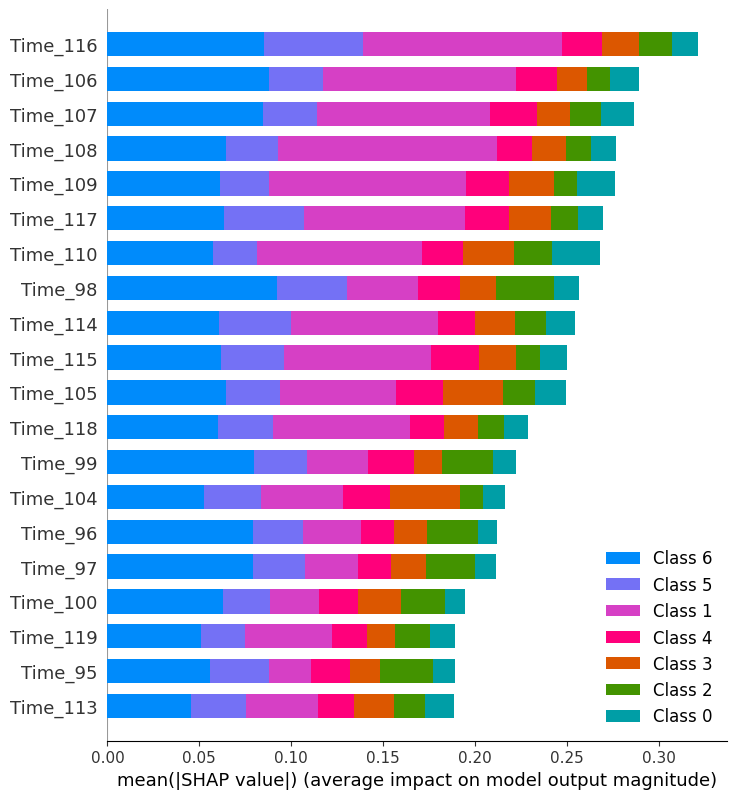

In [71]:
# Assuming X_train and X_test are shaped (n_samples, 120, 1)
print("X_train shape:", X_train.shape)  # Verify: e.g., (n_train, 120, 1)
print("X_test shape:", X_test.shape)    # Verify: e.g., (n_test, 120, 1)

# Flatten the last dimension (from 3D to 2D)
X_train_2d = X_train.reshape(X_train.shape[0], -1)  # Shape: (n_train, 120)
X_test_2d = X_test.reshape(X_test.shape[0], -1)    # Shape: (n_test, 120)
X_test_subset_2d = X_test_2d[:100]                  # Shape: (10, 120)

# Background sample (also 2D)
background = shap.sample(X_train_2d, 100)  # Shape: (100, 120)

# Wrapper function to match flattened input to model’s expected input
def model_predict_flattened(X):
    # Reshape back to (n_samples, 120, 1) for the CNN
    X_3d = X.reshape(-1, 120, 1)
    return model.predict(X_3d)  # Shape: (n_samples, num_classes)

# Use KernelExplainer with the flattened data
explainer = shap.KernelExplainer(model_predict_flattened, background)
shap_values = explainer.shap_values(X_test_subset_2d, nsamples=500)

# Plot summary (SHAP values will be a list of arrays, one per class)
shap.summary_plot(shap_values, X_test_subset_2d, feature_names=[f"Time_{i}" for i in range(120)])

In [ ]:
# Number of classes (from your label_mapping or model output)
num_classes = len(shap_values)

# Compute average SHAP value per time step for each class
shap_avg_per_class = [np.mean(class_shap, axis=0) for class_shap in shap_values]  # List of (120,) arrays

# Time steps (x-axis)
time_steps = np.arange(120)

# Create a Plotly figure
fig = go.Figure()

# Plot each class's average SHAP values
for class_idx, shap_avg in enumerate(shap_avg_per_class):
    fig.add_trace(
        go.Scatter(
            x=time_steps,
            y=shap_avg,
            mode="lines",
            name=f"Class {class_idx}",
            opacity=0.7,
            line=dict(width=2),
            hovertemplate="Time Step: %{x}<br>SHAP Value: %{y:.4f}<extra></extra>"
        )
    )

# Update layout for formatting
fig.update_layout(
    title="Average SHAP Values Over Time for Each Class",
    xaxis_title="Time Step",
    yaxis_title="Average SHAP Value",
    legend_title="Classes",
    width=1200,
    height=600,
    hovermode="x unified",  # Shows all classes' values on hover
    showlegend=True
)

# Add grid
fig.update_xaxes(showgrid=True, gridcolor="rgba(128, 128, 128, 0.2)", gridwidth=1)
fig.update_yaxes(showgrid=True, gridcolor="rgba(128, 128, 128, 0.2)", gridwidth=1)

# Display the plot
fig.show()

In [75]:
import plotly.graph_objects as go
import numpy as np

# Number of classes (from your label_mapping or model output)
num_classes = len(shap_values)

# Compute average SHAP value per time step for each class
shap_avg_per_class = [np.mean(class_shap, axis=0) for class_shap in shap_values]  # List of (120,) arrays

# Aggregate SHAP values across all classes (absolute sum across classes)
shap_aggregated = np.sum(np.abs(shap_avg_per_class), axis=0)  # Shape: (120,)

# Time steps (x-axis)
time_steps = np.arange(120)

# Create a Plotly figure
fig = go.Figure()

# Add a single trace for the aggregated absolute SHAP values
fig.add_trace(
    go.Scatter(
        x=time_steps,
        y=shap_aggregated,
        mode="lines",
        name="Aggregated Absolute SHAP",
        opacity=0.7,
        line=dict(width=2, color="blue"),  # Single color for clarity
        hovertemplate="Time Step: %{x}<br>Aggregated Absolute SHAP Value: %{y:.4f}<extra></extra>"
    )
)

# Update layout for formatting
fig.update_layout(
    title="Aggregated Absolute SHAP Values Over Time (10 Test Samples)",
    xaxis_title="Time Step",
    yaxis_title="Absolute SHAP Value (Magnitude)",
    width=1200,
    height=600,
    showlegend=True,  # Keep legend for clarity, though only one line
    hovermode="x"
)

# Add grid
fig.update_xaxes(showgrid=True, gridcolor="rgba(128, 128, 128, 0.2)", gridwidth=1)
fig.update_yaxes(showgrid=True, gridcolor="rgba(128, 128, 128, 0.2)", gridwidth=1)

# Display the plot
fig.show()